In [1]:
%matplotlib notebook
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from cognite import CogniteClient

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# API_KEY is stored in the environment
client = CogniteClient()

# Load data from CSV and organize it into dataframe

In [ ]:
data_dir = "data/"
df = pd.read_csv(data_dir+"Raw.csv", sep=';', index_col=None, header=2)

data = pd.concat([df['Unnamed: 0'], df['Unnamed: 2'], df['Unnamed: 4'], 
                  df['Unnamed: 6'], df['Unnamed: 8'], df['Unnamed: 10']], ignore_index=True)

data = data.to_frame()

data.columns = ['timestamp']
data['raw [nV]'] = pd.concat([df['Raw data signal [nV]'], df['Unnamed: 3'], df['Unnamed: 5'], 
                  df['Unnamed: 7'], df['Unnamed: 9'], df['Unnamed: 11']], ignore_index=True)

data.dropna(inplace=True)

### Convert string to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

### Resample data to 1S resolution
Raw_resampled = data.resample('1S').interpolate()

# Load raw sand detector data from CDP

In [2]:
tag = 'VAL_G16_SandSensor_RAW'
start = datetime.datetime(2018, 7, 2)
end = datetime.datetime(2018, 7, 30)
data = client.datapoints.get_datapoints(tag, start=start, end=end)
data = data.to_pandas()
data.timestamp = data.timestamp + 2*60*60*1000
data.timestamp = pd.to_datetime(data.timestamp, unit='ms')
data.set_index('timestamp', inplace=True)

# Resample data to 1S resolution
Raw_resampled = data.resample('1S').interpolate()

<IPython.core.display.Javascript object>


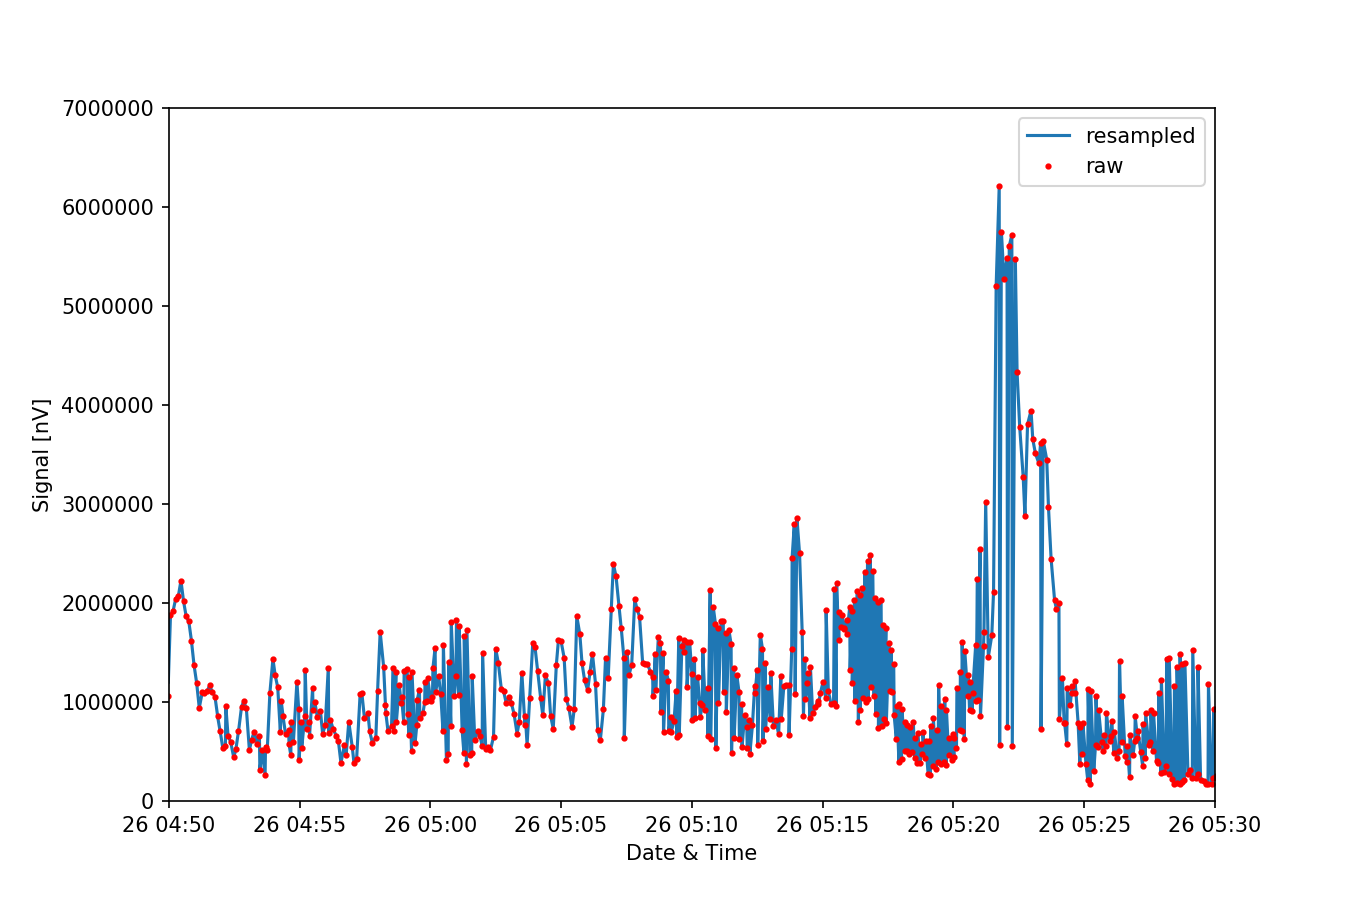

In [3]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(Raw_resampled, label='resampled')
ax.plot(data, 'ro', markersize=2, label='raw')
start = '2018-07-26 04:50'
end = '2018-07-26 05:30'
ax.set_xlim(start,end)
ax.set_ylim(0,0.7e7)
ax.set_ylabel('Signal [nV]')
ax.set_xlabel('Date & Time')
ax.legend()

# Power Spectral Density (PSD)

<IPython.core.display.Javascript object>


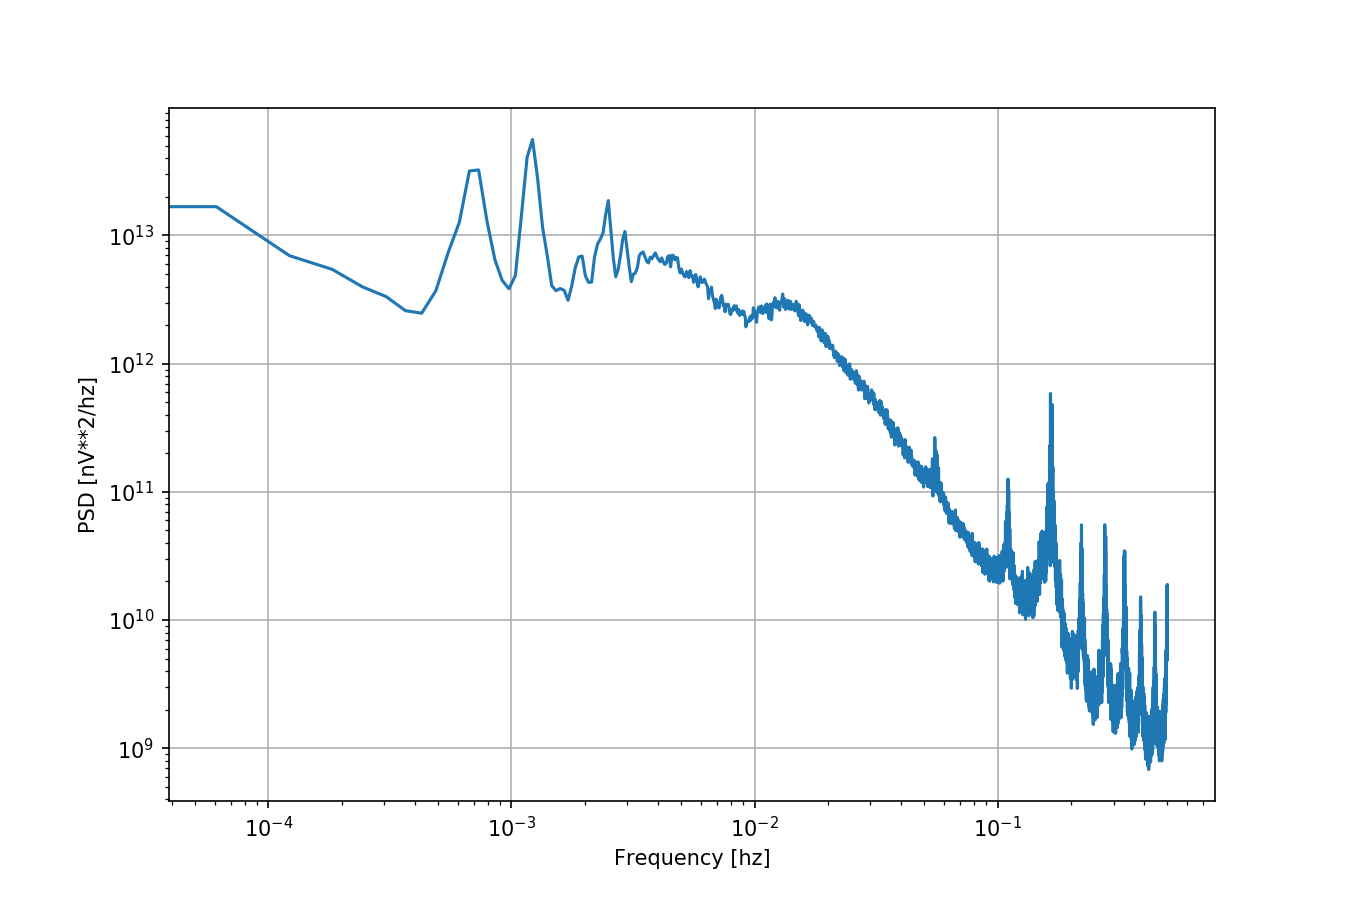

In [4]:
Fs = 1
f, Pxx = signal.welch(Raw_resampled.value, fs=Fs, nperseg=2**14, scaling='density')
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(f, Pxx)
#ax.tick_params(axis='y')
ax.set_ylabel('PSD [nV**2/hz]')
ax.set_xlabel('Frequency [hz]')
ax.grid(True)

# NOISE REMOVAL - Lowpass Frequency filter 

In [36]:
Fs = 1
nyq = 0.5 * Fs
cutoff_F = 0.01
order=6 # 

# Design the filter
b, a = signal.butter(order, Wn=cutoff_F/nyq, btype='lowpass', analog=False)

# Setup initial conditions of the filter
zi = signal.lfilter_zi(b, a)

# Apply the filter once
z, _ = signal.lfilter(b, a, Raw_resampled['value'], zi=zi*Raw_resampled['value'][0])

# Apply the filter a second time to have a zero phase delay 
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
w, h = signal.freqz(b, a, worN=2**8)

# Rebuild the filtered signal
Raw_resampled['lowpass'] = signal.filtfilt(b, a, Raw_resampled['value'])

<IPython.core.display.Javascript object>


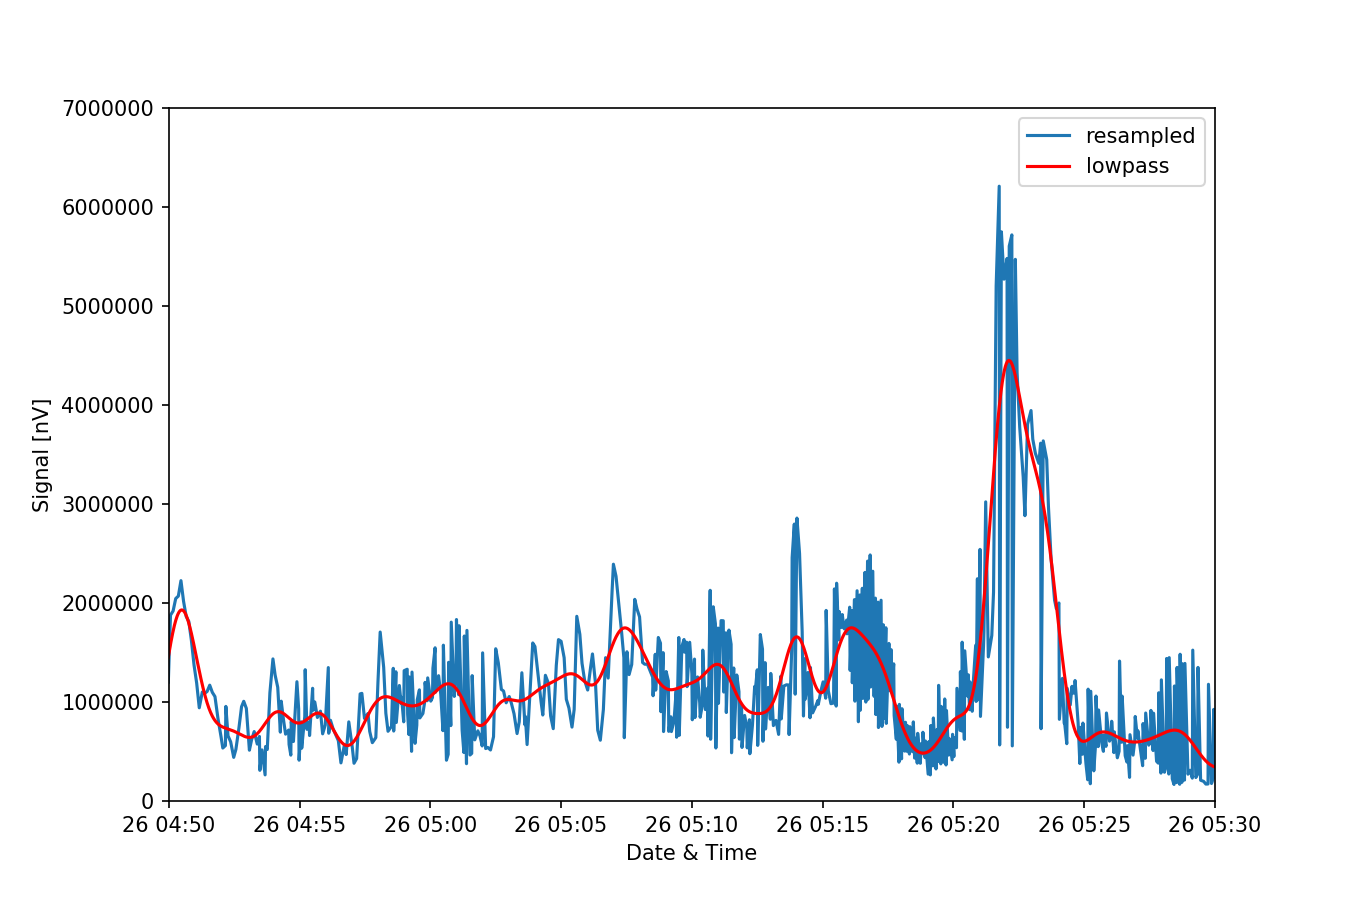

In [37]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(Raw_resampled.value, label='resampled')
ax.plot(Raw_resampled.lowpass, 'r', label='lowpass')
start = '2018-07-26 04:50'
end = '2018-07-26 05:30'
ax.set_xlim(start,end)
ax.set_ylim(0,0.7e7)
ax.set_ylabel('Signal [nV]')
ax.set_xlabel('Date & Time')
ax.legend()

# TREND REMOVAL - Highpass Frequency filter 

In [28]:
Fs = 1
nyq = 0.5 * Fs
cutoff_F = 0.01
order=3 # 

# Design the filter
b, a = signal.butter(order, Wn=cutoff_F/nyq, btype='highpass', analog=False)

# Setup initial conditions of the filter
zi = signal.lfilter_zi(b, a)

# Apply the filter once
z, _ = signal.lfilter(b, a, Raw_resampled['value'], zi=zi*Raw_resampled['value'][0])

# Apply the filter a second time to have a zero phase delay 
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
w, h = signal.freqz(b, a, worN=2**8)

# Rebuild the filtered signal
Raw_resampled['highpass'] = signal.filtfilt(b, a, Raw_resampled['value'])

<IPython.core.display.Javascript object>


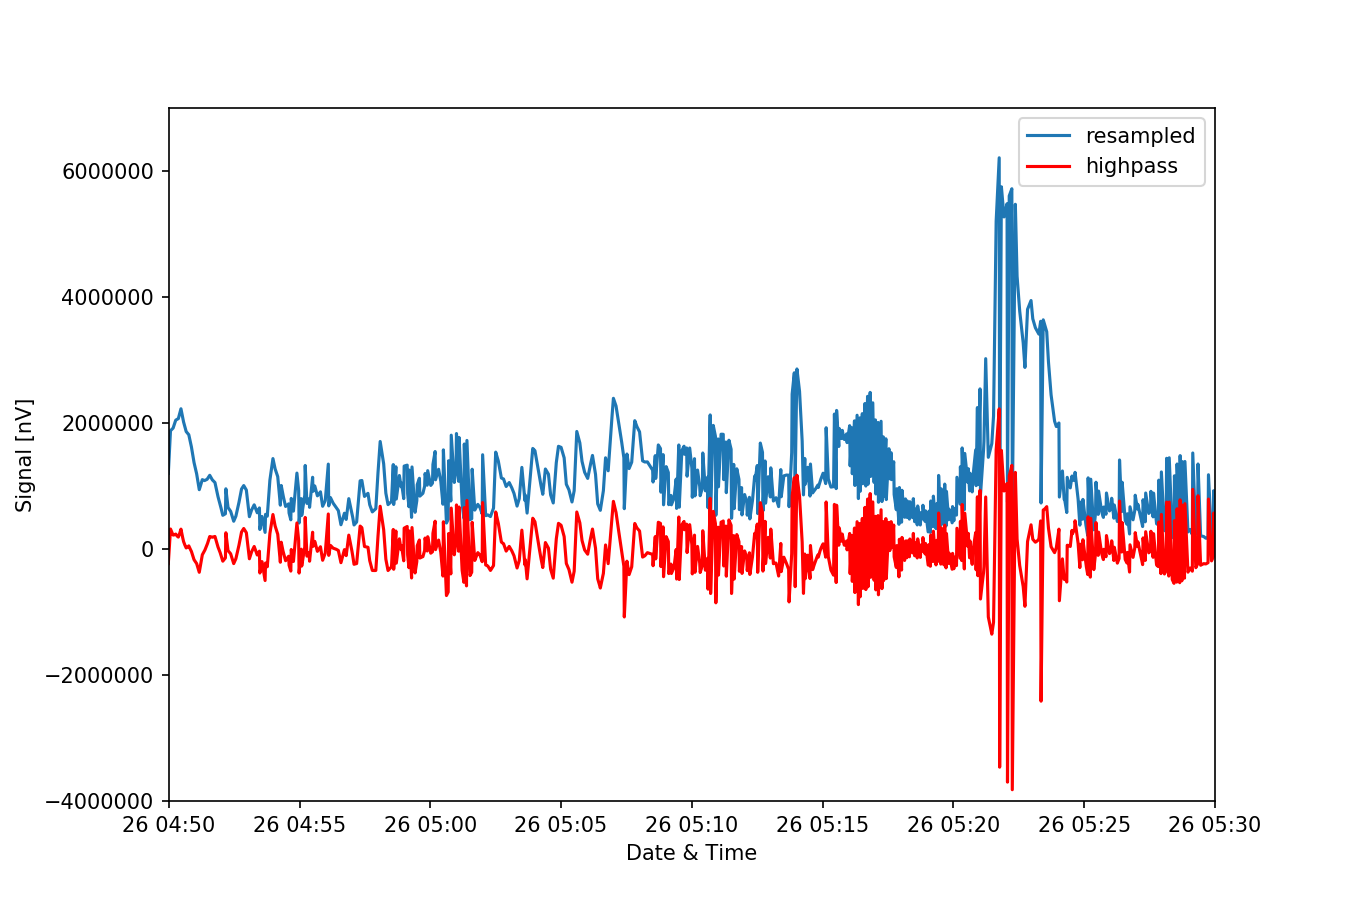

In [29]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(Raw_resampled.value, label='resampled')
ax.plot(Raw_resampled.highpass, 'r', label='highpass')
start = '2018-07-26 04:50'
end = '2018-07-26 05:30'
ax.set_xlim(start,end)
ax.set_ylim(-0.4e7,0.7e7)
ax.set_ylabel('Signal [nV]')
ax.set_xlabel('Date & Time')
ax.legend()

# EVENTS ISOLATION - Bandpass Frequency filter 

In [30]:
Fs = 1
nyq = 0.5 * Fs
low_F = 0.0003
high_F = 0.01
order=3 # 

# Design the filter
b, a = signal.butter(order, Wn=[low_F/nyq, high_F/nyq], btype='bandpass', analog=False)

# Setup initial conditions of the filter
zi = signal.lfilter_zi(b, a)

# Apply the filter once
z, _ = signal.lfilter(b, a, Raw_resampled['value'], zi=zi*Raw_resampled['value'][0])

# Apply the filter a second time to have a zero phase delay 
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
w, h = signal.freqz(b, a, worN=2**8)

# Rebuild the filtered signal
Raw_resampled['bandpass'] = signal.filtfilt(b, a, Raw_resampled['value'])

<IPython.core.display.Javascript object>


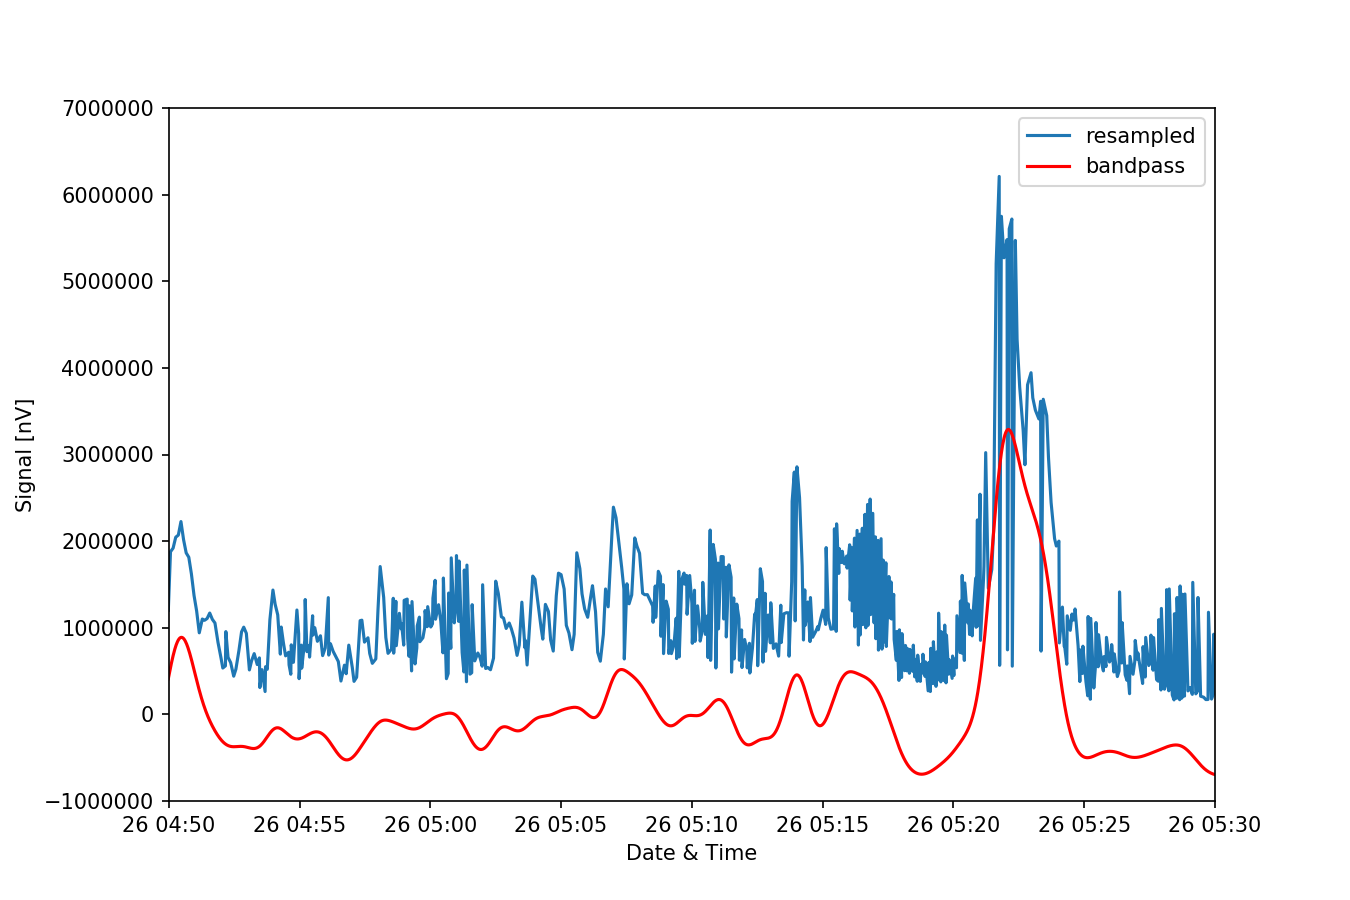

In [31]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(Raw_resampled.value, label='resampled')
ax.plot(Raw_resampled.bandpass, 'r', label='bandpass')
start = '2018-07-26 04:50'
end = '2018-07-26 05:30'
ax.set_xlim(start,end)
ax.set_ylim(-0.1e7,0.7e7)
ax.set_ylabel('Signal [nV]')
ax.set_xlabel('Date & Time')
ax.legend()